https://medium.com/mlearning-ai/traffic-light-detection-and-recognition-system-part-1-15a649906977

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from glob import glob
import sys
import sklearn.metrics as metrics
from tensorflow import keras
from tensorflow.keras.models import load_model
import shutil
from PIL import Image
import cv2
import time

saving model

In [2]:
MODEL_NAME = './faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
OUR_PATH = MODEL_NAME + '/frozen_inference_graph.pb'

DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

In [3]:
def download_model():
    import six.moves.urllib as urllib
    import tarfile

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

def load_graph():
    if not os.path.exists(OUR_PATH):
        download_model()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.compat.v2.io.gfile.GFile(OUR_PATH, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph

def select_boxes(boxes, classes, scores, score_threshold=0, target_class=10):
    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)

    sel_id = np.logical_and(sq_classes == target_class, 
                            sq_scores > score_threshold)

    return sq_boxes[sel_id]





### Hough Transfrom function

In [4]:
def detect_color(img,anno_left, anno_top, anno_right, anno_bot):
    
    mask1 = np.zeros_like(img[:,:,0])
    roi_corners1 = np.array([[(anno_left,anno_top), (anno_right,anno_top), (anno_right,anno_bot), (anno_left,anno_bot)]], dtype=np.int32)
    cv2.fillPoly(mask1, roi_corners1, 1)
    # Extract the ROIs using the masks
    roi1 = cv2.bitwise_and(img, img, mask=mask1)

    font = cv2.FONT_HERSHEY_SIMPLEX
    img = roi1
    cimg = img
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # color range
    lower_red1 = np.array([0,100,100])
    upper_red1 = np.array([10,255,255])
    lower_red2 = np.array([160,100,100])
    upper_red2 = np.array([180,255,255])
    lower_green = np.array([40,50,50])
    upper_green = np.array([90,255,255])
    # lower_yellow = np.array([15,100,100])
    # upper_yellow = np.array([35,255,255])
    lower_yellow = np.array([15,150,150])
    upper_yellow = np.array([35,255,255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    maskg = cv2.inRange(hsv, lower_green, upper_green)
    masky = cv2.inRange(hsv, lower_yellow, upper_yellow)
    maskr = cv2.add(mask1, mask2)

    size = img.shape
    # print size

    # hough circle detect
    r_circles = cv2.HoughCircles(maskr, cv2.HOUGH_GRADIENT, 1, 80,
                                param1=50, param2=10, minRadius=0, maxRadius=30)

    g_circles = cv2.HoughCircles(maskg, cv2.HOUGH_GRADIENT, 1, 60,
                                    param1=50, param2=5, minRadius=0, maxRadius=30)

    y_circles = cv2.HoughCircles(masky, cv2.HOUGH_GRADIENT, 1, 30,
                                    param1=50, param2=15, minRadius=0, maxRadius=30)

    # traffic light detect
    r = 5
    bound = 4.0 / 10
    if r_circles is not None:
        r_circles = np.uint16(np.around(r_circles))

        for i in r_circles[0, :]:
            if i[0] > size[1] or i[1] > size[0]or i[1] > size[0]*bound:
                continue

            h, s = 0.0, 0.0
            for m in range(-r, r):
                for n in range(-r, r):

                    if (i[1]+m) >= size[0] or (i[0]+n) >= size[1]:
                        continue
                    h += maskr[i[1]+m, i[0]+n]
                    s += 1
            if h / s > 50:
                cv2.circle(cimg, (i[0], i[1]), i[2]+10, (0, 255, 0), 2)
                cv2.circle(maskr, (i[0], i[1]), i[2]+30, (255, 255, 255), 2)
                cv2.putText(cimg,'RED',(i[0], i[1]), font, 1,(255,0,0),2,cv2.LINE_AA)

    if g_circles is not None:
        g_circles = np.uint16(np.around(g_circles))

        for i in g_circles[0, :]:
            if i[0] > size[1] or i[1] > size[0] or i[1] > size[0]*bound:
                continue

            h, s = 0.0, 0.0
            for m in range(-r, r):
                for n in range(-r, r):

                    if (i[1]+m) >= size[0] or (i[0]+n) >= size[1]:
                        continue
                    h += maskg[i[1]+m, i[0]+n]
                    s += 1
            if h / s > 100:
                cv2.circle(cimg, (i[0], i[1]), i[2]+10, (0, 255, 0), 2)
                cv2.circle(maskg, (i[0], i[1]), i[2]+30, (255, 255, 255), 2)
                cv2.putText(cimg,'GREEN',(i[0], i[1]), font, 1,(255,0,0),2,cv2.LINE_AA)

    if y_circles is not None:
        y_circles = np.uint16(np.around(y_circles))

        for i in y_circles[0, :]:
            if i[0] > size[1] or i[1] > size[0] or i[1] > size[0]*bound:
                continue

            h, s = 0.0, 0.0
            for m in range(-r, r):
                for n in range(-r, r):

                    if (i[1]+m) >= size[0] or (i[0]+n) >= size[1]:
                        continue
                    h += masky[i[1]+m, i[0]+n]
                    s += 1
            if h / s > 50:
                cv2.circle(cimg, (i[0], i[1]), i[2]+10, (0, 255, 0), 2)
                cv2.circle(masky, (i[0], i[1]), i[2]+30, (255, 255, 255), 2)
                cv2.putText(cimg,'YELLOW',(i[0], i[1]), font, 1,(255,0,0),2,cv2.LINE_AA)

In [5]:
class TLDetector(object):
    def __init__(self):
        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.compat.v1.Session(graph=self.detection_graph)

        # dummy session
        dummy_image = np.zeros((224, 224, 3))
        self.detect_multi_object(dummy_image,0.1)
        self.traffic_light_box = None
        self.classified_index = 0

    def extract_graph_components(self):
        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
    
    def detect_multi_object(self, image_np, score_threshold):

        image_np_expanded = np.expand_dims(image_np, axis=0)

        (boxes, scores, classes, num) = self.sess.run([self.detection_boxes, 
                                                       self.detection_scores, 
                                                       self.detection_classes, 
                                                       self.num_detections],
                                                       feed_dict={self.image_tensor: image_np_expanded})

        sel_boxes = select_boxes(boxes=boxes, 
                                 classes=classes, 
                                 scores=scores,
                                 score_threshold=score_threshold, 
                                 target_class=10) # Class 10 is for Traffic Lights

        return sel_boxes

start_time = time.time()
tld = TLDetector()
print("--- %s seconds ---" % (time.time() - start_time))

--- 25.997518301010132 seconds ---


In [6]:
def get_annots(image_np, sel_box):
    annots_temp = []
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    annots_temp.extend((left, top,right,  bottom))
    
    return annots_temp

def tl_detection(test_file):
  start_time = time.time()
  im = Image.open(test_file)
  image_np = np.asarray(im)
  boxes=tld.detect_multi_object(image_np,score_threshold=0.2)
  annotations = []
  if len(boxes)>0:
    for box in boxes:
      temp_annots = get_annots(image_np,box)
      annotations.append(temp_annots)

  img = cv2.imread(test_file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print("Found {} annotations:".format(len(annotations)))
  i=0
  for anno in annotations:
      anno_left = int(anno[0])
      anno_top = int(anno[1])
      anno_right = int(anno[2])
      anno_bot = int(anno[3])
      print("\tClass: '{}' at [{},{},{},{}]".format("traffic light", anno_left, anno_top, anno_right, anno_bot))

      cv2.rectangle(img, (anno_left, anno_top), (anno_right, anno_bot), (0,0,255), 5)
      detect_color(img,anno_left,anno_top,anno_right,anno_bot)

      plt.rcParams['figure.figsize'] = [14, 10]
  plt.imshow(img)
  plt.show()
  print("--- %s seconds ---" % (time.time() - start_time))

  return annotations

Found 3 annotations:
	Class: 'traffic light' at [939,482,1015,655]
	Class: 'traffic light' at [106,87,193,271]
	Class: 'traffic light' at [950,706,981,776]


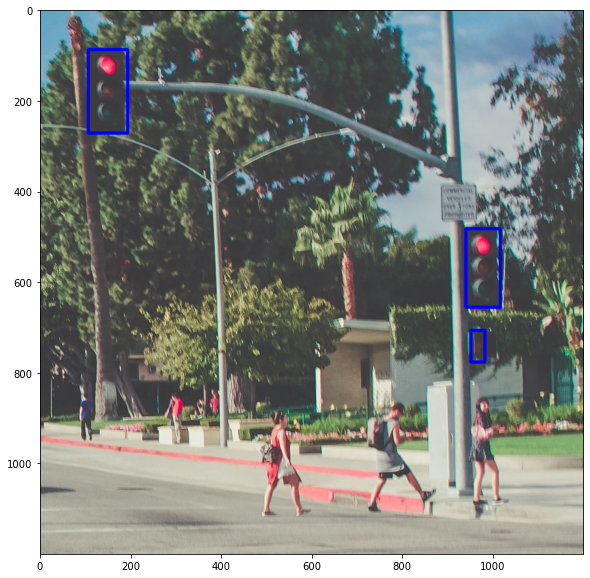

--- 7.621279716491699 seconds ---


[[939.2531633377075,
  482.05883502960205,
  1015.3866291046143,
  655.4586410522461],
 [106.95714354515076,
  87.28127181529999,
  193.1031346321106,
  271.52307629585266],
 [950.3796815872192, 706.7920446395874, 981.089973449707, 776.8335342407227]]

In [7]:
test_file = 'dataset-card.jpg'
annotations=tl_detection(test_file)
annotations

Detected Traffic Light: RED


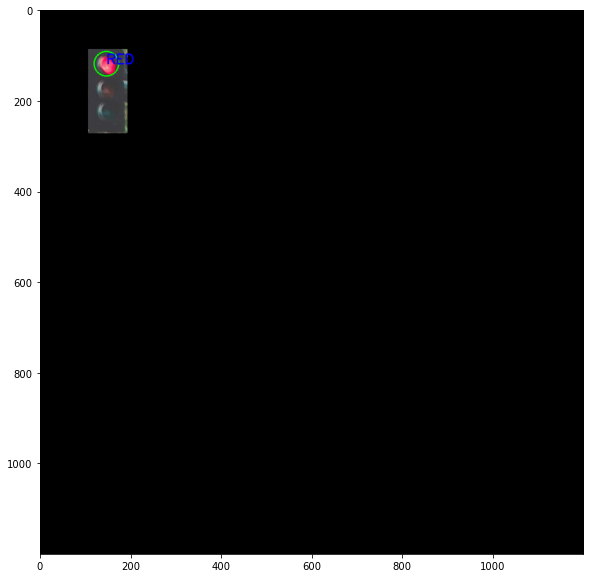

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
test_file = 'dataset-card.jpg'
anno_left, anno_top, anno_right, anno_bot = 106, 86, 192, 271
img = cv2.imread(test_file)
mask1 = np.zeros_like(img[:,:,0])
roi_corners1 = np.array([[(anno_left,anno_top), (anno_right,anno_top), (anno_right,anno_bot), (anno_left,anno_bot)]], dtype=np.int32)
cv2.fillPoly(mask1, roi_corners1, 1)
roi1 = cv2.bitwise_and(img, img, mask=mask1)

font = cv2.FONT_HERSHEY_SIMPLEX
img = roi1
cimg = img
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_red1 = np.array([0,100,100])
upper_red1 = np.array([10,255,255])
lower_red2 = np.array([160,100,100])
upper_red2 = np.array([180,255,255])
lower_green = np.array([40,50,50])
upper_green = np.array([90,255,255])
lower_yellow = np.array([15,150,150])
upper_yellow = np.array([35,255,255])

mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
maskg = cv2.inRange(hsv, lower_green, upper_green)
masky = cv2.inRange(hsv, lower_yellow, upper_yellow)
maskr = cv2.add(mask1, mask2)

size = img.shape
r = 5
bound = 4.0 / 10

r_circles = cv2.HoughCircles(maskr, cv2.HOUGH_GRADIENT, 1, 80, param1=50, param2=10, minRadius=0, maxRadius=30)
g_circles = cv2.HoughCircles(maskg, cv2.HOUGH_GRADIENT, 1, 60, param1=50, param2=5, minRadius=0, maxRadius=30)
y_circles = cv2.HoughCircles(masky, cv2.HOUGH_GRADIENT, 1, 30, param1=50, param2=15, minRadius=0, maxRadius=30)

if r_circles is not None:
    r_circles = np.uint16(np.around(r_circles))

    for i in r_circles[0, :]:
        if i[0] > size[1] or i[1] > size[0] or i[1] > size[0]*bound:
            continue

        h, s = 0.0, 0.0
        for m in range(-r, r):
            for n in range(-r, r):
                if (i[1]+m) >= size[0] or (i[0]+n) >= size[1]:
                    continue
                h += maskr[i[1]+m, i[0]+n]
                s += 1
        if h / s > 50:
            cv2.circle(cimg, (i[0], i[1]), i[2]+10, (0, 255, 0), 2)
            cv2.circle(maskr, (i[0], i[1]), i[2]+30, (255, 255, 255), 2)
            cv2.putText(cimg, 'RED', (i[0], i[1]), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
            print("Detected Traffic Light: RED")

if g_circles is not None:
    g_circles = np.uint16(np.around(g_circles))

    for i in g_circles[0, :]:
        if i[0] > size[1] or i[1] > size[0] or i[1] > size[0]*bound:
            continue

        h, s = 0.0, 0.0
        for m in range(-r, r):
            for n in range(-r, r):
                if (i[1]+m) >= size[0] or (i[0]+n) >= size[1]:
                    continue
                h += maskg[i[1]+m, i[0]+n]
                s += 1
        if h / s > 100:
            cv2.circle(cimg, (i[0], i[1]), i[2]+10, (0, 255, 0), 2)
            cv2.circle(maskg, (i[0], i[1]), i[2]+30, (255, 255, 255), 2)
            cv2.putText(cimg, 'GREEN', (i[0], i[1]), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
            print("Detected Traffic Light: GREEN")

if y_circles is not None:
    y_circles = np.uint16(np.around(y_circles))

    for i in y_circles[0, :]:
        if i[0] > size[1] or i[1] > size[0] or i[1] > size[0]*bound:
            continue

        h, s = 0.0, 0.0
        for m in range(-r, r):
            for n in range(-r, r):
                if (i[1]+m) >= size[0] or (i[0]+n) >= size[1]:
                    continue
                h += masky[i[1]+m, i[0]+n]
                s += 1
        if h / s > 50:
            cv2.circle(cimg, (i[0], i[1]), i[2]+10, (0, 255, 0), 2)
            cv2.circle(masky, (i[0], i[1]), i[2]+30, (255, 255, 255), 2)
            cv2.putText(cimg, 'YELLOW', (i[0], i[1]), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
            print("Detected Traffic Light: YELLOW")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.imshow(cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
plt.show()


In [9]:
cap = cv2.VideoCapture("C:\\Users\\u27d41\Desktop\\TrafficLightClassification\\FasterRCNNandHough\\input\\project.mp4")

# Get the video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec for the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_width, frame_height))

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        break

    # Perform traffic light detection on the frame
    boxes = tld.detect_multi_object(frame, score_threshold=0.2)
    annotations = []

    if len(boxes) > 0:
        for box in boxes:
            temp_annots = get_annots(frame, box)
            annotations.append(temp_annots)

    # Draw bounding boxes and perform additional processing
    for anno in annotations:
        anno_left = int(anno[0])
        anno_top = int(anno[1])
        anno_right = int(anno[2])
        anno_bot = int(anno[3])

        cv2.rectangle(frame, (anno_left, anno_top), (anno_right, anno_bot), (0, 0, 255), 5)
        detect_color(frame, anno_left, anno_top, anno_right, anno_bot)

    # Write the frame with bounding boxes to the output video
    output_video.write(frame)

    # Display the resulting frame
    cv2.imshow('Traffic Light Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and the output video
cap.release()
output_video.release()

# Close all OpenCV windows
cv2.destroyAllWindows()
